<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
from datetime import datetime
import tensorflow
import keras
from keras import backend as K
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from keras.constraints import max_norm

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import Dropout
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Input
import time
import tensorflow as tf
from sklearn.metrics import f1_score,roc_auc_score, log_loss, confusion_matrix

from collections import Counter
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import seaborn as sns

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import pickle
# %run "../../src/data_preparation/utils.py"

# print(get_notebook_kernel_id())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6784352959224167040
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11648197457805500586
physical_device_desc: "device: XLA_CPU device"
]


In [6]:
def f1_score__(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [7]:
now = datetime.now()
log_dir = "../tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

train = pd.read_pickle("../../data/processed/train.pickle")
valid = pd.read_pickle("../../data/processed/valid.pickle")
test = pd.read_pickle("../../data/processed/test.pickle")
submission = pd.read_pickle("../../data/processed/submission.pickle")


feature_cols = list(train.drop(["LABEL", "ID"], 1).columns)
random_seed = 2019
early_stop = 10
num_epoch = 200

cate_cols = list()

label_col = "LABEL"

must_remove_cols = ['ID', label_col] 

feature_cols = list(set(feature_cols) - set(must_remove_cols))
numeric_cols = feature_cols

minmax_scaler = preprocessing.MinMaxScaler()
train[numeric_cols] = train[numeric_cols].fillna(value=0)
train[numeric_cols] = minmax_scaler.fit_transform(train[numeric_cols])

valid[numeric_cols] = valid[numeric_cols].fillna(value=0)
valid[numeric_cols] = minmax_scaler.fit_transform(valid[numeric_cols])

test[numeric_cols] = test[numeric_cols].fillna(value=0)
test[numeric_cols] = minmax_scaler.fit_transform(test[numeric_cols])

submission[numeric_cols] = submission[numeric_cols].fillna(value=0)
submission[numeric_cols] = minmax_scaler.fit_transform(submission[numeric_cols])


train["LABEL"] = train["LABEL"].astype(bool)
valid["LABEL"] = valid["LABEL"].astype(bool)
test["LABEL"] = test["LABEL"].astype(bool)


### Cross validation and train model

# print("must_remove_cols:", must_remove_cols)
# print("features_columns_model:", features_columns_model)
# 


...RUNNING


In [12]:
train.head()

,TOTUSJH_0,TOTBSQ_0,TOTPOT_0,TOTUSJZ_0,ABSNJZH_0,SAVNCPP_0,USFLUX_0,TOTFZ_0,MEANPOT_0,EPSZ_0,...,SKEW(data.MEANGBH)_rank,SKEW(data.MEANJZH)_rank,SKEW(data.TOTFY)_rank,SKEW(data.MEANJZD)_rank,SKEW(data.MEANALP)_rank,SKEW(data.TOTFX)_rank,SKEW(data.EPSY)_rank,SKEW(data.EPSX)_rank,SKEW(data.R_VALUE)_rank,SKEW(data.XR_MAX)_rank
0,0.012432,0.006034,0.000113,0.010601,0.005269,0.004935,0.012294,0.957243,0.000052,0.184349,...,0.723285,0.473128,0.991755,0.509587,0.365954,0.044795,0.002957,0.383642,0.089135,1.000000
1,0.040377,0.034750,0.000351,0.035163,0.004354,0.008102,0.079674,0.877640,0.000022,0.102286,...,0.526742,0.431616,0.509912,0.491924,0.491533,0.146473,0.810165,0.679466,0.312892,1.000000
2,0.301238,0.367420,0.017835,0.248071,0.152840,0.126390,0.333058,0.739221,0.000324,0.405714,...,0.188102,0.418746,0.834627,0.865837,0.079169,0.790171,0.202183,0.555645,0.718852,0.097551
3,0.599759,0.525692,0.022078,0.511156,0.162862,0.135093,0.549244,0.542388,0.000239,0.377992,...,0.205400,0.768939,0.288816,0.069752,0.934351,0.595725,0.855416,0.629956,0.266585,0.009866
4,0.001430,0.000593,0.000010,0.001367,0.000127,0.000114,0.001421,0.968701,0.000033,0.181647,...,0.485763,0.584784,0.534166,0.628054,0.554186,0.950607,0.139296,0.694993,0.531112,1.000000


In [26]:
for c in list(train.columns.values):
    print(c)

TOTUSJH_0
TOTBSQ_0
TOTPOT_0
TOTUSJZ_0
ABSNJZH_0
SAVNCPP_0
USFLUX_0
TOTFZ_0
MEANPOT_0
EPSZ_0
MEANSHR_0
SHRGT45_0
MEANGAM_0
MEANGBT_0
MEANGBZ_0
MEANGBH_0
MEANJZH_0
TOTFY_0
MEANJZD_0
MEANALP_0
TOTFX_0
EPSY_0
EPSX_0
R_VALUE_0
XR_MAX_0
TOTUSJH_1
TOTBSQ_1
TOTPOT_1
TOTUSJZ_1
ABSNJZH_1
SAVNCPP_1
USFLUX_1
TOTFZ_1
MEANPOT_1
EPSZ_1
MEANSHR_1
SHRGT45_1
MEANGAM_1
MEANGBT_1
MEANGBZ_1
MEANGBH_1
MEANJZH_1
TOTFY_1
MEANJZD_1
MEANALP_1
TOTFX_1
EPSY_1
EPSX_1
R_VALUE_1
XR_MAX_1
TOTUSJH_2
TOTBSQ_2
TOTPOT_2
TOTUSJZ_2
ABSNJZH_2
SAVNCPP_2
USFLUX_2
TOTFZ_2
MEANPOT_2
EPSZ_2
MEANSHR_2
SHRGT45_2
MEANGAM_2
MEANGBT_2
MEANGBZ_2
MEANGBH_2
MEANJZH_2
TOTFY_2
MEANJZD_2
MEANALP_2
TOTFX_2
EPSY_2
EPSX_2
R_VALUE_2
XR_MAX_2
TOTUSJH_3
TOTBSQ_3
TOTPOT_3
TOTUSJZ_3
ABSNJZH_3
SAVNCPP_3
USFLUX_3
TOTFZ_3
MEANPOT_3
EPSZ_3
MEANSHR_3
SHRGT45_3
MEANGAM_3
MEANGBT_3
MEANGBZ_3
MEANGBH_3
MEANJZH_3
TOTFY_3
MEANJZD_3
MEANALP_3
TOTFX_3
EPSY_3
EPSX_3
R_VALUE_3
XR_MAX_3
TOTUSJH_4
TOTBSQ_4
TOTPOT_4
TOTUSJZ_4
ABSNJZH_4
SAVNCPP_4
USFLUX_4
TOTFZ_4
M

In [10]:
num_features = len(feature_cols)
class_weight=  {0 : 1 , 1: 1}
num_features

1850

In [9]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [8]:
train_valid = pd.concat([train, valid]).reset_index(drop=True)
train_valid["LABEL"] = train_valid["LABEL"].astype(bool)

In [11]:
model = Sequential()
model.add(Dense(300, input_dim=num_features, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate = 0.5))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate = 0.5))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))


model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               555300    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)      

In [9]:
## FINAL
t_start = time.time()


model = Sequential()
model.add(Dense(300, input_dim=num_features, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate = 0.5))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate = 0.5))
model.add(Dense(200, kernel_initializer='normal', activation='relu', kernel_constraint=max_norm(3)))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

# early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
#                                                 patience=early_stop, verbose=0, mode='auto', baseline=None)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_f1', min_delta=0,
                                                patience=early_stop, verbose=0, mode='max', baseline=None)
mcp_save = keras.callbacks.ModelCheckpoint('neural_new', save_best_only=True, monitor='val_f1', mode='max')


callback_list = [tensorboard_callback, early_stopping_callback, mcp_save]


# model.compile(loss='binary_crossentropy', optimizer=adam)
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[f1])


# Create data for this fold
X_train, y_train = train_valid[feature_cols], train_valid.LABEL
X_valid, y_valid = test[feature_cols], test.LABEL
X_submission  = submission[feature_cols]
print("...running")


model.fit(x=X_train, y=y_train, batch_size=128, epochs=num_epoch, verbose=1, 
          validation_data=(X_valid, y_valid),
          shuffle=True, callbacks=callback_list, class_weight=class_weight)

model.load_weights(filepath = 'neural_new')

val_loss = model.evaluate(X_valid, y_valid)

print(val_loss)

### finalllll
y_pred_prob = model.predict(X_submission)[:,0]

t_end = time.time()
print("running time = ", t_end-t_start)

...running
Train on 169254 samples, validate on 27006 samples
Epoch 1/200
169254/169254 [==============================] - 32s 188us/step - loss: 0.2479 - f1: 0.5799 - val_loss: 0.2498 - val_f1: 0.6428
Epoch 2/200
169254/169254 [==============================] - 31s 183us/step - loss: 0.2358 - f1: 0.6082 - val_loss: 0.2457 - val_f1: 0.6665
Epoch 3/200
169254/169254 [==============================] - 31s 181us/step - loss: 0.2339 - f1: 0.6106 - val_loss: 0.2475 - val_f1: 0.6724
Epoch 4/200
169254/169254 [==============================] - 31s 180us/step - loss: 0.2320 - f1: 0.6082 - val_loss: 0.2413 - val_f1: 0.7130
Epoch 5/200
169254/169254 [==============================] - 30s 179us/step - loss: 0.2304 - f1: 0.6116 - val_loss: 0.2443 - val_f1: 0.6577
Epoch 6/200
169254/169254 [==============================] - 30s 179us/step - loss: 0.2292 - f1: 0.6113 - val_loss: 0.2492 - val_f1: 0.5989
Epoch 7/200
169254/169254 [==============================] - 31s 180us/step - loss: 0.2284 - f1: 0

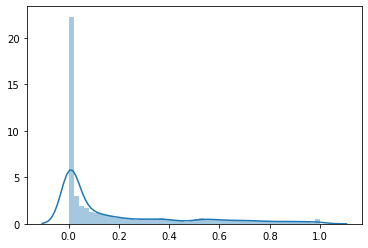

In [10]:
y_valid_pred_prob = model.predict_proba(X_valid)[:,0]
sns.distplot(y_valid_pred_prob)

In [37]:
valid_df = pd.DataFrame(data={"pred_neural": (y_valid_pred_prob), "label_neural": y_valid})
valid_df.label_neural = valid_df.label_neural.astype(int)
valid_df.to_csv("../../data/intermediate/neural_65698.csv", index=False)
print(valid_df.shape)
valid_df.head()

(27006, 2)


,pred_neural,label_neural
0,0.630928,1
1,0.033467,0
2,0.003996,0
3,0.048318,0
4,0.021180,0


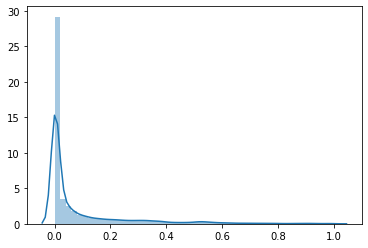

In [11]:
sns.distplot(y_pred_prob)

In [25]:
### finalllll
thres = 0.18


y_pred = list(y_pred_prob > thres)
count_res = Counter(y_pred)

print(count_res, count_res[1]*100/count_res[0])

Counter({False: 141785, True: 31727}) 22.376838170469373


In [38]:
submit_prob_df = pd.DataFrame(data={"pred_neural": y_pred_prob, "label": [np.nan]*len(y_pred_prob)})
submit_prob_df.to_csv("../../data/intermediate/neural_65698_sub_thres0.16.csv", index=False)
print(submit_prob_df.shape)
submit_prob_df.head()

(173512, 2)


,pred_neural,label
0,0.002763,NaN
1,0.020722,NaN
2,0.001714,NaN
3,0.075390,NaN
4,0.002952,NaN


In [30]:
#### SUBMISSION
submission_df = pd.DataFrame({"Id": submission.ID, "ClassLabel": list(y_pred)})
print(Counter(submission_df.ClassLabel))
submission_df.ClassLabel = submission_df.ClassLabel.astype(int)
submission_df.to_csv("../../data/output/ouput_neural_{}.csv".format(str("dont know")), index=False)
submission_df.head(10)

# Counter({0: 143966, 1: 29546})

Counter({False: 141785, True: 31727})


,Id,ClassLabel
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,1
6,7,0
7,8,0
8,9,0
9,10,0


In [31]:
_713 = pd.read_csv("../../data/output/ouput_0.7133364529714553 (1).csv")
sum(_713.ClassLabel == submission_df.ClassLabel)/len(submission_df)

0.9648957997141409

In [32]:
Counter(_713.ClassLabel)

Counter({0: 141074, 1: 32438})

In [33]:
Counter(submission_df.ClassLabel)

Counter({0: 141785, 1: 31727})